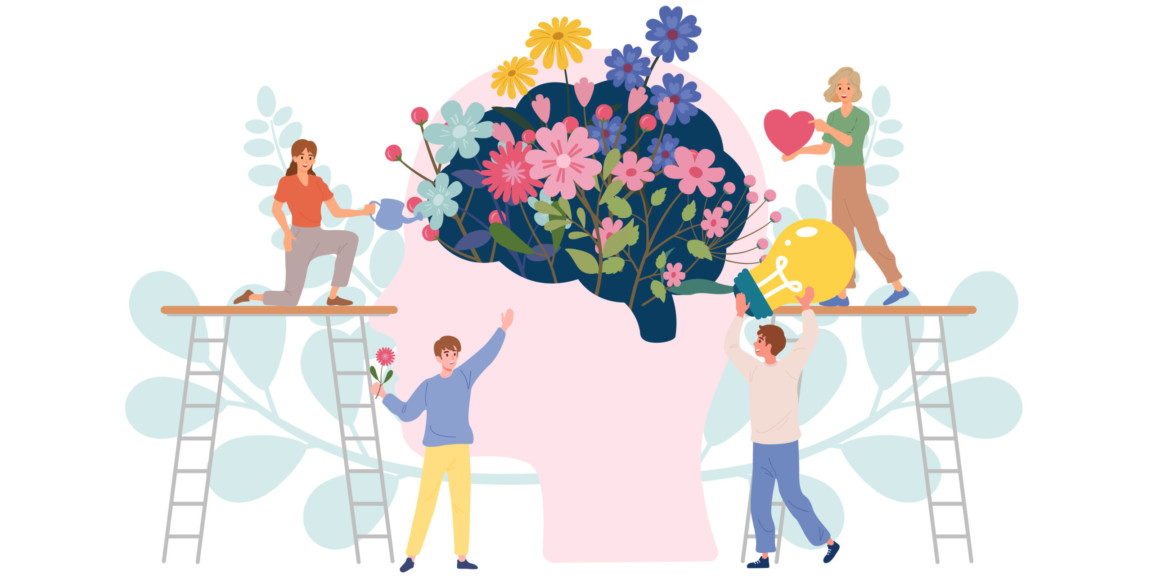

# Global Mental Health Prevalence - Predicting Depression and Anxiety

Caroline Miller

May 02, 2023

O'Neil Cohort - Data Science

**Goal:** The endstate after conducting this project is a model which can predict depression rates better than the baseline model and to provide some conclusions as to why these disorders are affecting the global population and which regions of the world are most afflicted.

**Project Description:** This project looks at meantal health data from every country spanning 1990 to 2017. Global spikes in mental health disorders affects me personally, and the effects of living with these disorders can be devasting to both the afflicted individual and their friends and families. The project aims to detect trends in these disorders, explore the different distributions throughout the world, and predict how these disorders may affect the citizens of the world in the future. the project uses time series forecasting and linear regression to predict depression on a global scale.

#### Imports

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# modeling
import modeling_evaluate as me
import wrangle as w
import explore as e

# visualize 
import matplotlib.pyplot as plt

import scipy.stats as stats
import numpy as np
import pandas as pd

# Plt defaults
# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(14, 8))
plt.rc('font', size=16)

#### Data Dictionary

| **Object Returned** | **Description** |
|:-------------------|:--------------------------------|
| 1. Entity | The name of the country or region. (String) |
| 2. Code | The ISO code of the country or region. (String) |
| 3. Year | The year the data was collected. (Integer) |
| 4. Schizophrenia (%) | The percentage of people with schizophrenia in the country or region. (Float) |
| 5. Bipolar disorder (%) | The percentage of people with bipolar disorder in the country or region. (Float) |
| 6. Eating disorders (%) | The percentage of people with eating disorders in the country or region. (Float) |
| 7. Anxiety disorders (%) | The percentage of people with anxiety disorders in the country or region. (Float)  |
| 8. Drug use disorders (%) | The percentage of people with drug use disorders in the country or region. (Float)   |
| 9. Depression (%) | The percentage of people with depression in the country or region. (Float)   |
| 10. Alcohol use disorders (%) | The percentage of people with alcohol use disorders in the country or region. (Float)  |


### Acquire

The original dataset was acquired from Kaggle. Please see the link below:

https://www.kaggle.com/datasets/thedevastator/global-mental-health-disorders

    - 108,552 rows
    - 10 columns
    - 4 separate dataframes in one CSV file
    - Observations from 1990 to 2017
    - Entities include countries and regions

### Prepare

In [2]:
mental_health_df, population_df, rates_df, depressive_rates_df = w.separate_data()

mental_health_df = w.clean_mental_health_data(mental_health_df)
depressive_rates_df = w.clean_depressive_rates_data(depressive_rates_df)
population_df = w.clean_population_data(population_df)
rates_df = w.clean_rates_data(rates_df)

yearly_disorders, yearly_prevalence_sex, yearly_depressive_rates, yearly_suicide_rates = w.yearly_aggregation()

df = w.merge_yearly_aggregation()

train_yearly, test_yearly = w.split_yearly_data()

train, validate, test = w.split_data(df)

train_scaled, validate_scaled, test_scaled = w.scale_data(train, validate, test, columns_to_scale=train.columns)

X_train, X_validate, X_test, y_train, y_validate, y_test = me.X_y_datasets()

**The wrangle modeule contains functions which conduct the following on the dataframe:**

1. Separate the dataframe into the four distinct dataframes

    - mental_health_df:  contains the percentages of each entities' population who are afflicted with the mental disorder outlined in the columns (see data dictionary) for each year from 1990 to 2017
    - population_df:  contains the prevalence of mental health disorders (percentage) by year by entity by sex (female/male) and the entities' population for each year
    - rates_df:  contains the percentages of suicide and depressive disorder of each entity for that year, the entities' population, and the computed number of people who commited suicide or suffered from depressive disorder that year in that country
    - depressive_rates_df:  contains the number of people in each entity for that year who suffered from depressive disorder
    
2. Cleans each dataframe, to include renaming columns, filling in null values in the code column with the entity name, dropping column names which do not pertain to that dataframe, dropping entries which fall outside of the years 1990 - 2017, converting datatypes from object to float, and dropping null values - note: null values appeared uner entities whihc describe regions, not countries; this project aggregates using the mean therefore regional entries would not contribute to the overall yearly averages

3. Groups the data by year, and computes the mean for each feature (global averages)

4. Merges each dataframe to combine all features by year

5. Splits data into 3 samples to avoid data leakage

6. Scales the 3 sample datasets

### Exploratory Data Analysis

**The Linear Regression modeling predicts the prevalence of depressive disorders throughout the world. The trend of this disroder is illustrated below.**

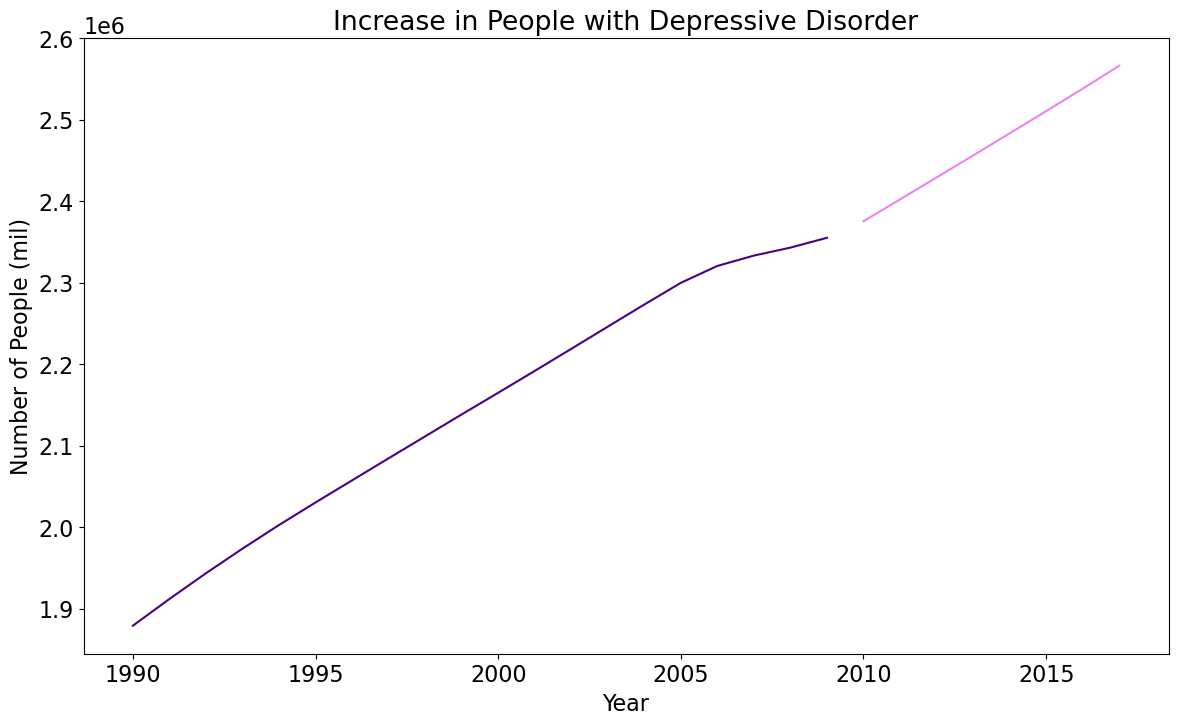

In [3]:
w.viz_num_depressed(train_yearly, test_yearly)

**The global rate of change in mental disorders appears to be static. While seemingly unchanging the difference in mental health affliction between males and females is significantly different; there are about twice as many females who suffer from mental health disorders globally.**

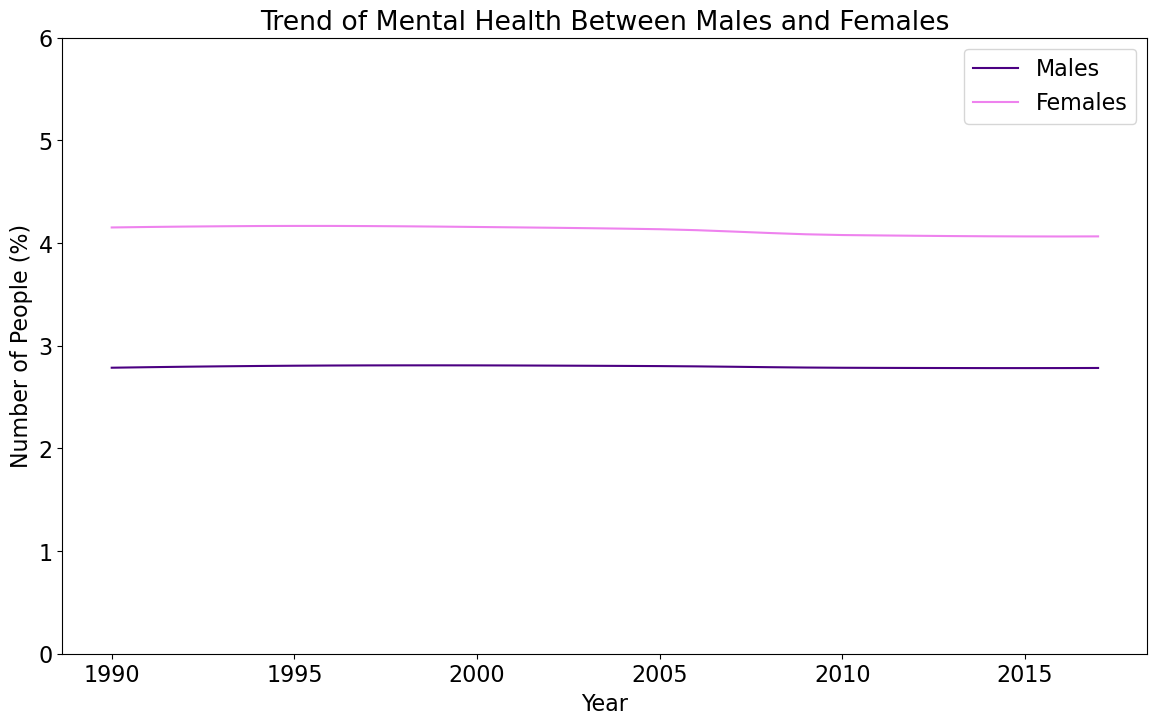

In [4]:
e.viz_gender_diff(population_df)

**Questions to Explore:**
    
    1. Is there a difference in the rate of depression in the United States versus the rest of the world?
    2. Are the rates of any of the mental health disorders decreasing? What is the rate for each disorder from 1990 to 2017?
    3. Is there a difference in the rates of the happiest country vs the least happy country?
    4. Is there a difference in rates of depression between two populations: 1) Iceland, Portugal, Canada, Australia and Sweden and 2) the rest of the world?

**Question 1:** Is there a difference in the rate of depression in the United States versus the rest of the world?

To test this question, I will conduct a means comparison hypothesis test using the rates_df dataset.

In [5]:
# Creating two sub dataframes: 1) 1990-2017 United States and 2) 1990-2017 world

us_rates_df = rates_df[rates_df.entity == 'United States']
world_rates_df = rates_df[rates_df.entity != 'United States']

H$_O$: There is no difference in the means of rates of depression between the world and the US.

H$_A$: There is difference in the means of rates of depression between the world and the US.

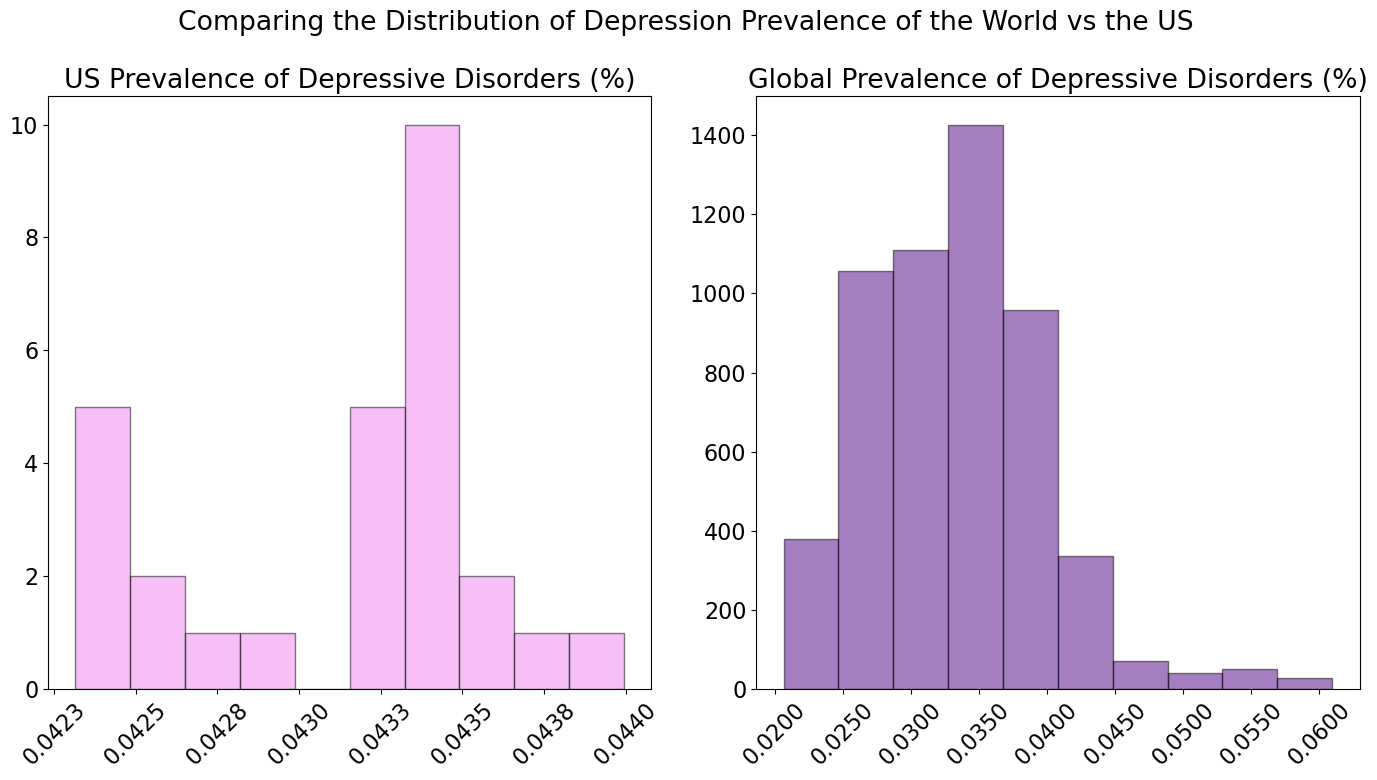

<Figure size 500x300 with 0 Axes>

In [6]:
e.viz_us_vs_world(us_rates_df, world_rates_df)

In [7]:
us = us_rates_df.percentage_depressive_disorder
world = world_rates_df.percentage_depressive_disorder.mean()

t_stat, p = stats.ttest_1samp(us, world)
α = 0.05
if p < α:
    print('We must reject the null hypothesis and conclude with some confidence that the means are different.')

We must reject the null hypothesis and conclude with some confidence that the means are different.


The mean depressive disorder prevalence for the US is different than that of the world. Is the US's depressive prevalence greater than that of the rest of the world?

H$_O$: The mean rate of depression for the US is less than or equal to that of the rest of the world.

H$_A$: The mean rate of depression for the US is greater than that of the rest of the world.

In [8]:
if ((p / 2) < α) and (t_stat > 0):
    print('We must reject the null hypothesis and conclude that the mean for the US is greater than or equal to that of the rest of the world.')

We must reject the null hypothesis and conclude that the mean for the US is greater than or equal to that of the rest of the world.


**Takeaway:** The rates of depression in the US are greater than those globally.

**Question 2:** Are the rates of any of the mental health disorders decreasing? What is the rate for each disorder from 1990 to 2017?

To explore this set of questions, I will use the mental_health_df

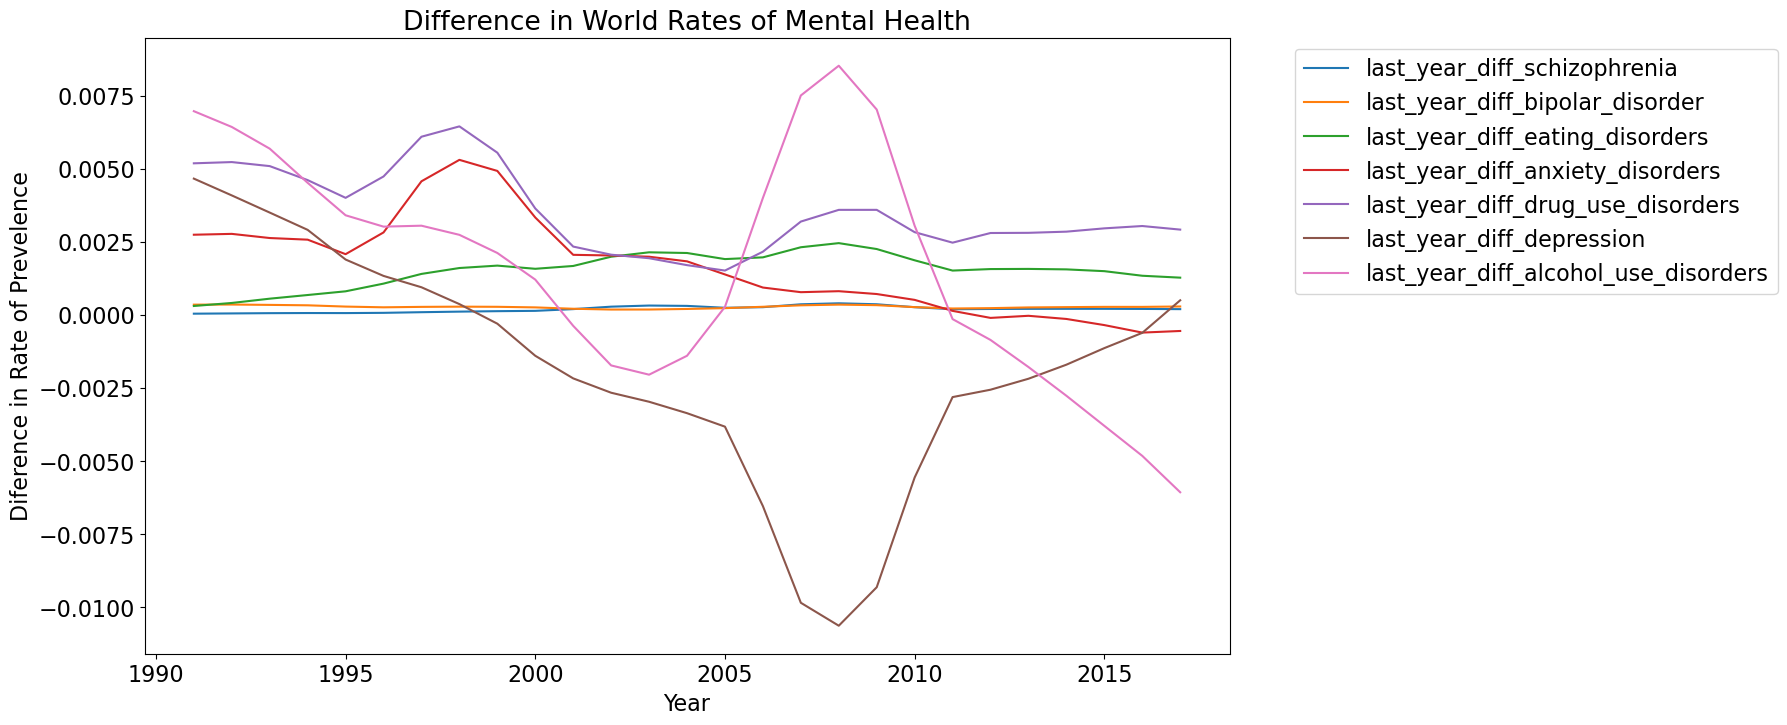

In [9]:
# calling function from explore modeule which creates a dataframe which contains the difference 
#from year to year for each disorder

# calling function from explore modeule which creates a visualiztion to illustrate the change in the 
# rate of each disorder over time (1990 - 2017)

diff_df = e.create_diff_df(mental_health_df)
e.viz_diff_df(diff_df)

In [10]:
change_in_rates = e.start_to_end_diff(rates_df, yearly_disorders)
change_in_rates

year,1990,2017,change_over_time
population,5.431311e+07,7.695605e+07,2.264293e+07
percentage_suicide,1.268699e-04,1.026680e-04,-2.420183e-05
percentage_depressive_disorder,3.359131e-02,3.278426e-02,-8.070437e-04
num_suicide,8.269010e+03,7.685582e+03,-5.834286e+02
num_depressed,1.879130e+06,2.566030e+06,6.869000e+05


**Takeaway:** All mental health disorders other than depression have been increasing in the world's population from 1990 to 2017. The rates_df confirms that the percent of population effected by suicide and depression has indeed decreased, though the raw number of people with depression has increased. This may be due to the increase in the global population during this time period.

**Question 3:** Is there a difference in the rates of the happiest country vs the least happy country?

According to the World Happiness Report, in 2017 the happiest country in the world was Norway, and the least happy country was Afghanistan.

Sources: https://worldhappiness.report/ed/2017/#:~:text=Norway%20tops%20the%20global%20happiness,in%20a%20tightly%20packed%20bunch.

To answer this question, I will conduct a two sample means comparison hypothesis test.

In [11]:
# creating two dataframes which contains the yearly aggregated data for the countries of Afghanistan 
# and Norway

afghanistan = rates_df[rates_df.entity == 'Afghanistan'].percentage_depressive_disorder
norway = rates_df[rates_df.entity == 'Norway'].percentage_depressive_disorder

H$_O$: Afghanistan's percentage depressive disorder and Norway's percentage depressive disorder have equal variance.

H$_A$: Afghanistan's percentage depressive disorder and Norway's percentage depressive disorder have inequal variance.

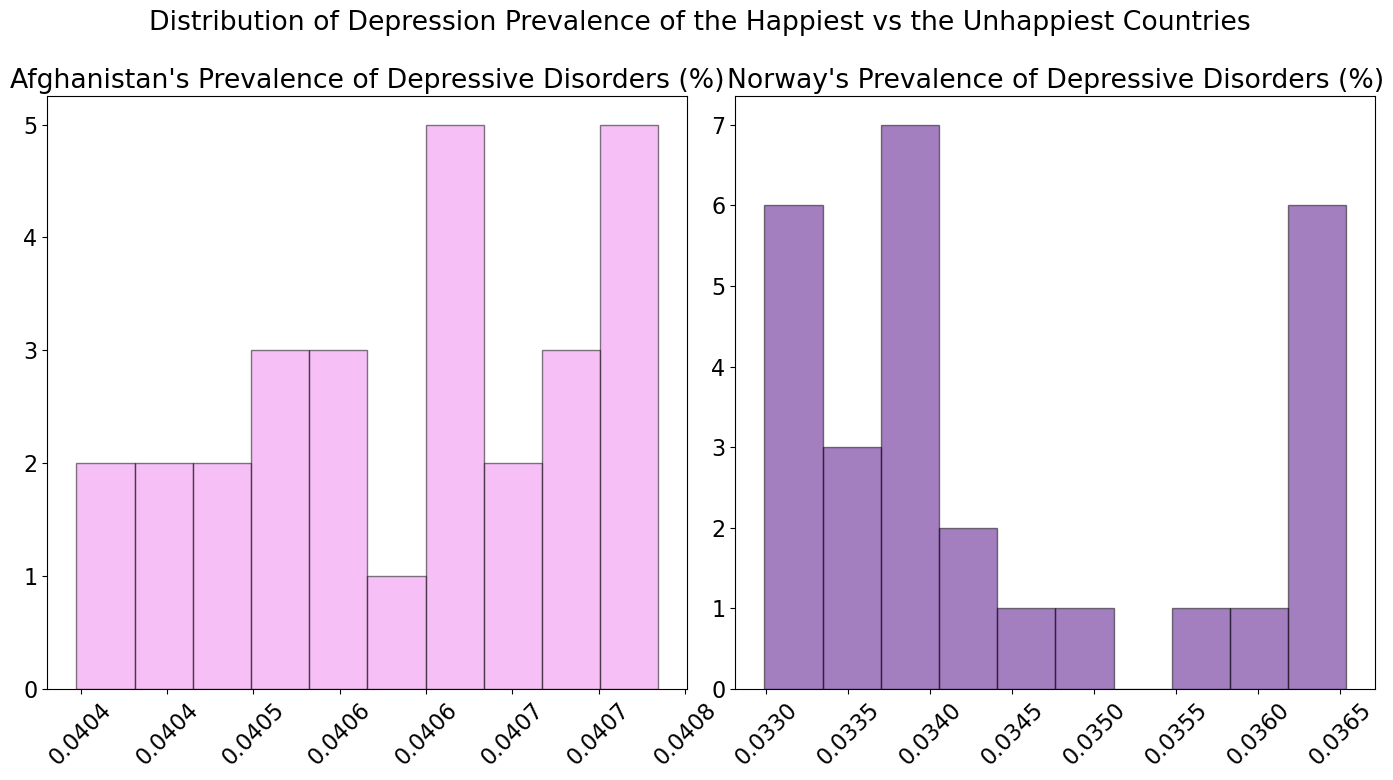

<Figure size 500x300 with 0 Axes>

In [12]:
e.viz_happy_unhappy(afghanistan, norway)

In [13]:
# testing for equal variance between the two samples

α = 0.05

t_stat, p = stats.levene(afghanistan, norway)

if p < α:
    print('We must reject the null hypothesis and conclude with some confidence that the two countires\' depression rates have inequal variance.')

We must reject the null hypothesis and conclude with some confidence that the two countires' depression rates have inequal variance.


H$_O$: Afghanistan's mean percentage depressive disorder and Norway's mean percentage depressive disorder do not differ significantly. 

H$_A$: Afghanistan's mean percentage depressive disorder and Norway's mean percentage depressive disorder  differ significantly. 

In [14]:
t_stat, p = stats.ttest_ind(afghanistan, norway, equal_var=False)

if p < α:
    print('We must reject the null hypothesis, and conclude with some confidence that the  two means differ.')

We must reject the null hypothesis, and conclude with some confidence that the  two means differ.


**Takeaway:** This test affirms that the data in fact supports that Norway was happier than Afghanistan over the years 1990 to 2017 based on the depressive disorder percentages.

**Question 4:** Is there a difference in rates of depression between two populations: 1) Iceland, Portugal, Canada, Australia and Sweden and 2) the rest of the world?

According to the World Happiness Report, the top 5 happiest countries in the world are represented in the sample outlined above. The following test aims to see if the depressive disorder prevalence in these countries is less than the rest of th world.

In [15]:
# Creating a subset which contains the top 5 happiest countries in the world and a subset which 
# contains the data for the rest of the world

happy_countries = rates_df[(rates_df.entity == 'Iceland') | (rates_df.entity == 'Portugal') | (rates_df.entity == 'Canada') | (rates_df.entity == 'Australia') | (rates_df.entity == 'Sweden')].percentage_depressive_disorder
world = rates_df[~(rates_df.entity == 'Iceland') | (rates_df.entity == 'Portugal') | (rates_df.entity == 'Canada') | (rates_df.entity == 'Australia') | (rates_df.entity == 'Sweden')].percentage_depressive_disorder

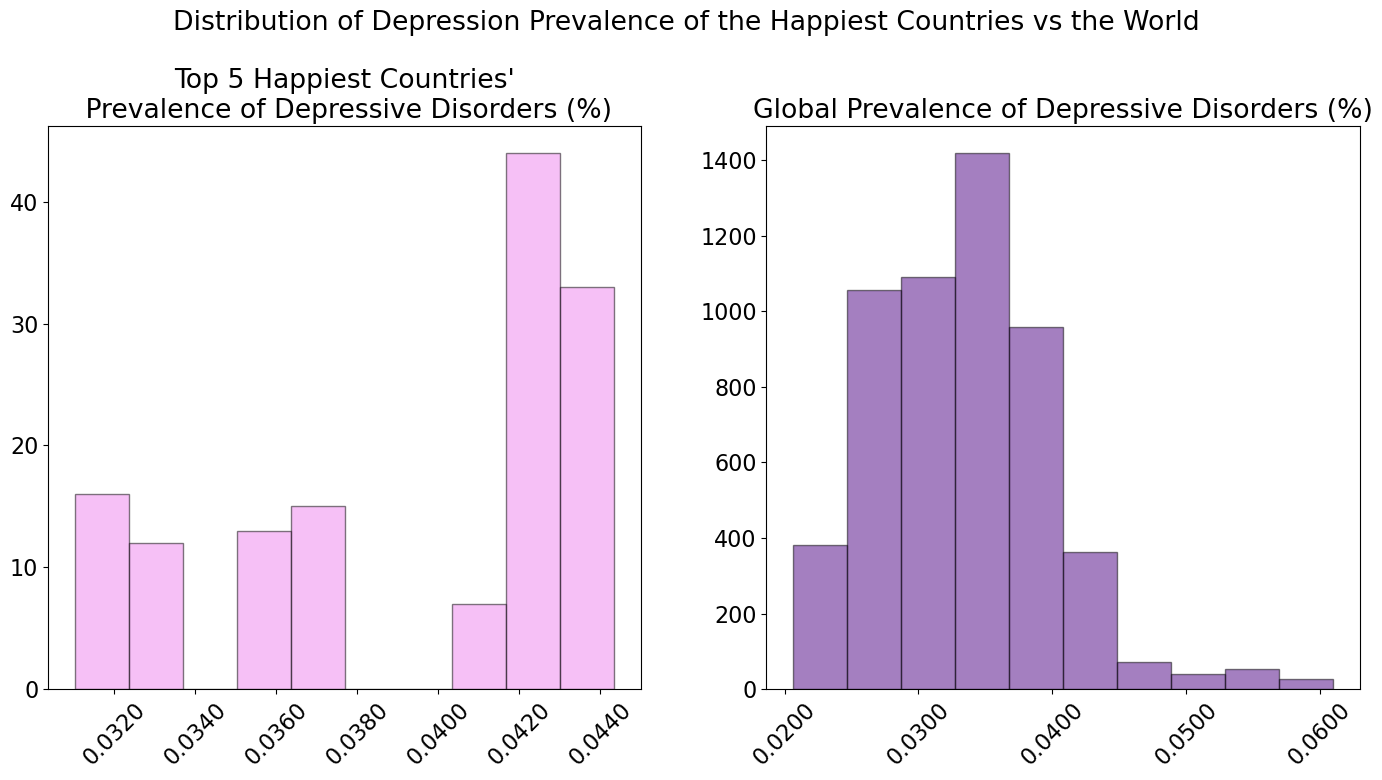

<Figure size 500x300 with 0 Axes>

In [16]:
e.viz_happy_vs_world(happy_countries, world)

H 𝑂 : There is no difference in the means of rates of depression between the world and the top 5 happiest countries.

H 𝐴 : There is difference in the means of rates of depression between the world and the top 5 happiest countries.

In [17]:
t_stat, p = stats.ttest_1samp(happy_countries, world.mean())
α = 0.05
if p < α:
    print('We must reject the null hypothesis and conclude with some confidence that the means are different.')

We must reject the null hypothesis and conclude with some confidence that the means are different.


The mean depressive disorder prevalence for the two samples are different. Does this mean that the depressive disorder prevalence in the 5 happiest countries is lower than the rest of the world?

H 𝑂 : The mean rate of depression in the top 5 happiest coutries is less than or equal to that of the rest of the world.

H 𝐴 : The mean rate of depression of the top 5 happiest countries is greater than that of the rest of the world.

In [18]:
if ((p / 2) < α) and (t_stat > 0):
    print('We must reject the null hypothesis and conclude that the mean for the top 5 happiest countries is greater than that of the rest of the world.')

We must reject the null hypothesis and conclude that the mean for the top 5 happiest countries is greater than that of the rest of the world.


**Takeaways:**  Contrary to what we may have predicted, we see that the data does show that the happiest countries in the world have a greater percentage of the population effected by depressive disorders.

**Explore Conclusion:** 

The top 5 "happiest countries" according to the World Happines report from 2017 actually have higher depression rates than the global
mean depression rate. 

The average depression and anxiety rates for the least happy nation is higher than the happiest nation.

The anxiety and depression rates in the US are higher than at of the world. 

Prevalence of all disorders besides depression are increasing. 

### Modeling

### Time Series - Forecasting

**Last Observed Value**

In [19]:
me.get_time_series_eval_df()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Predi

,model_type,target_var,rmse
0,last_observed_value,prevelance_depressive_disorder,334699.0
1,last_observed_value,anxiety_disorders,0.0
2,simple_average,prevelance_depressive_disorder,772934.0
3,simple_average,anxiety_disorders,0.0
4,moving_average,prevelance_depressive_disorder,334699.0
5,moving_average,anxiety_disorders,0.0
6,holts_optimized,prevelance_depressive_disorder,6551549.0
7,holts_optimized,anxiety_disorders,0.0


It appears that the best peforming Time Series model is the Moving Average model.

Let's test on this model, and evaluate its performance.

In [20]:
me.test_best_forecaster()

The RMSE on the test dataset for depression is 815449.0035915383 using the rolling average model.
The RMSE on the test dataset for anxiety is 0.006412699862971066 using the rolling average model.


**Takeaways:** The Time Series models did not do very well in predicting the prevalance of depressive disorders, and while it seems it did okay in predicting the global anxiety disorder percentage, the RMSE may be misleading on the surface because the numbers ae fairly consistant and the number of observations is small.

### Linear Regression

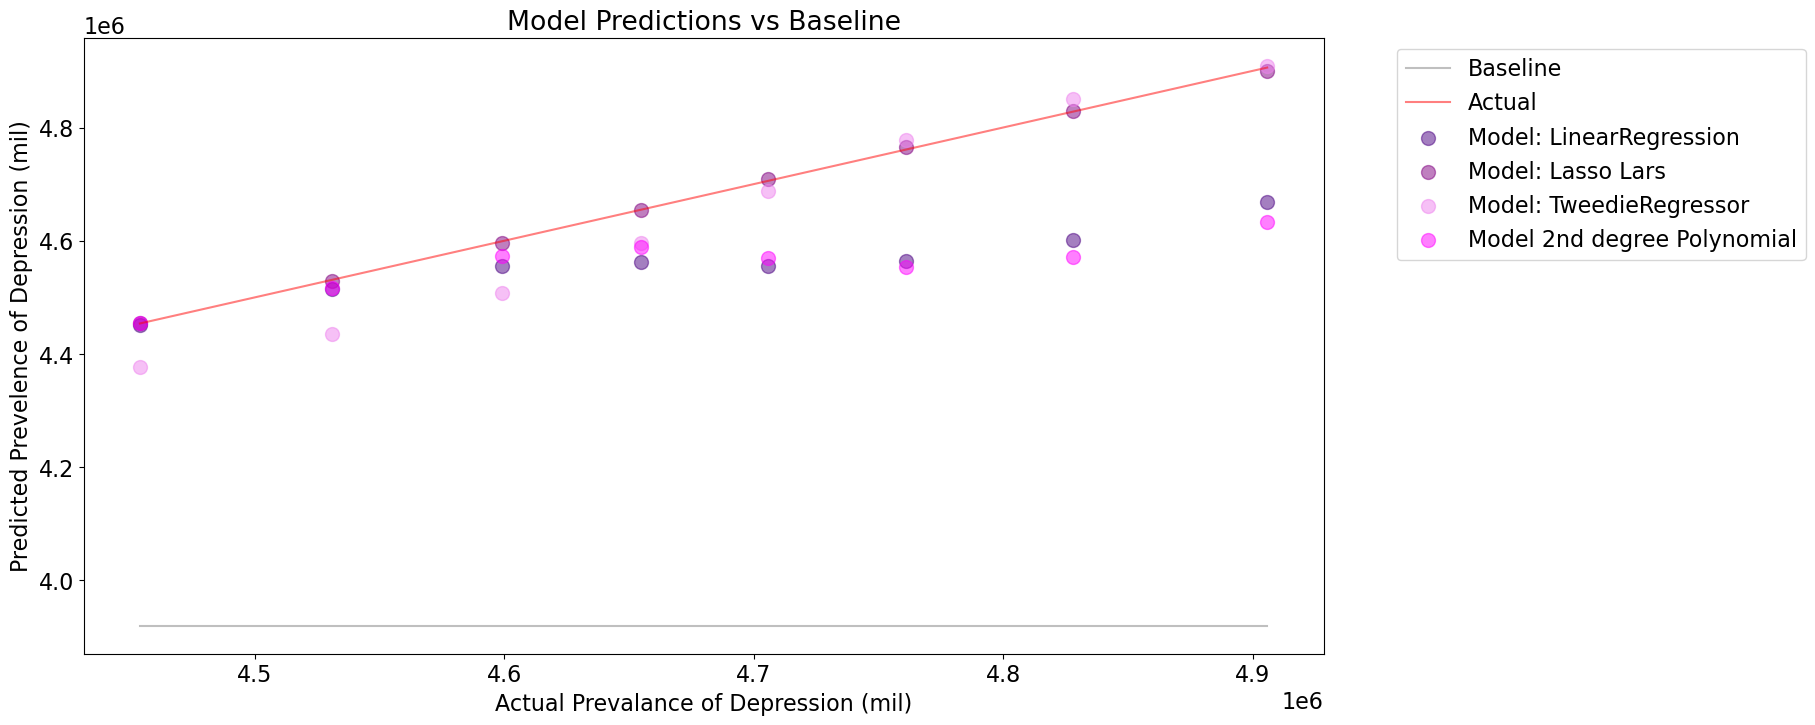

,model,RMSE_train,RMSE_validate,R2_validate
0,OLS_Regressor,4.978129e-10,149642.994065,0.608792
1,lasso_alpha,8.887831e+02,3226.240179,0.999485
2,glm_gamma,3.223301e+04,59107.731458,0.895602
3,quadratic,5.280103e-10,160983.355464,0.456246
4,mean_baseline,2.722166e+05,772933.792573,0.000000


In [21]:
me.get_regression_eval_df(X_train, y_train, X_validate, y_validate, X_test)

#### Testing on the Best Performing Model

In [22]:
me.test_on_best(X_train, y_train, y_validate, X_test, y_test)

RMSE for LassoLars Model using Linear Regression
Out-of-Sample Performance:  33160.761287652815

The LassoLars model performed 87.81824270971035% better than the baseline


**Modeling Conclusion:** My time series models did not perform very well on a continuously increasing metric like global depression rates. After fine tuning the LassoLars model, I thought I may see some overfitting. The differences in RMSE scores for the train, validate, and test sets were a little turbulent, but the model still performed better than any of the other models on the test set compared to the validate and train sets. The model was able to perform **87.82% better than baseline**.

### Project Conclusion

The original intent for this project was to cerate a model which could effectively predict the trends for mental health disorders, create features based off of the populations of the countries who consume the most pharmaceutical products using the prevalence rates, and to try and calculate the annual sales of these drugs.

This project currently meets the first goal outlined. the LassoLars model performs 87% better than the mean baseline for depression rates.

#### Recommendations

For the Time Series analysis, resampling the data to months or quarters would provide a larger dataset. This could provide greater insight into whether mental health flucuates seasonally or based off of local/international incidents. 

This project's aggregation of yearly averages most likely ignores mental health issues unique to certain parts of the world or certain countries. creating subsets based off of region or country would be advantageous to understanding the different mental health crises of individuals in certain areas who have different cultures and quality of life.

#### Next Steps

1. Bin and explore the data for each region of the world.
2. Research the countries or regions which consume the most pharmaceutical drugs for mental health disorders.
3. Research the cost of these drugs and calculate the potential annual sales of these drugs per mental health disorder. 
4. Forecast the sales of each drug category as they relate to the grower global population and the growing prevalence of mental health disorders.